In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import transformers
from transformers import AutoModelForTokenClassification, AutoTokenizer, AutoModel
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torch.utils.data import DataLoader, Dataset
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix
from copy import deepcopy
from IPython.display import clear_output
from huggingface_hub import notebook_login
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
    
from src.preprocessing.make_dataset import ImageLayoutDataset
import warnings
warnings.filterwarnings("ignore")

In [3]:
notebook_login()

In [4]:
!mkdir logs

mkdir: cannot create directory ‘logs’: File exists


In [5]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
model_name = "few_shot_learning"
dataset_name = "sroie"

In [6]:
logging.basicConfig(filename='logs/few_shot_learning_cord.log', encoding='utf-8', level= logging.INFO)

## Importing source and support dataset

In [7]:
source_dataset = load_dataset(
    "nielsr/funsd",
    cache_dir = "/Data/pedro.silva/"
)
support_dataset = load_dataset(
    "darentang/sroie",
    cache_dir = "/Data/pedro.silva/"
)

In [8]:
model = AutoModel.from_pretrained(
    "microsoft/layoutlm-base-uncased",
    cache_dir = "/Data/pedro.silva/"
).to(device)

tokenizer = AutoTokenizer.from_pretrained(
    "microsoft/layoutlm-base-uncased",
    cache_dir = "/Data/pedro.silva/"
)

Some weights of LayoutLMModel were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['layoutlm.embeddings.word_embeddings.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
source_dataset['train'].features['ner_tags'].feature.names

['O',
 'B-HEADER',
 'I-HEADER',
 'B-QUESTION',
 'I-QUESTION',
 'B-ANSWER',
 'I-ANSWER']

In [10]:
valid_labels ={
    0: 0,
    1: 1,
    2: 1,
    3: 2,
    4: 2,
    5: 3,
    6: 3,
    7: 4,
    8: 4
}

source_df = ImageLayoutDataset(
    source_dataset['train'],
    tokenizer,
    valid_labels_keymap= valid_labels
)

  0%|          | 0/149 [00:00<?, ?it/s]

100%|██████████| 149/149 [00:01<00:00, 130.27it/s]


In [11]:
input = source_df[0]

In [12]:
out = model(
    input_ids=input['input_ids'].reshape(1,-1), 
    bbox= input['bbox'].reshape([1, 512, 4]),
    attention_mask=input['attention_mask'].reshape(1,-1), 
    token_type_ids=input['token_type_ids'].reshape(1,-1),
)

In [13]:
out.last_hidden_state.shape

torch.Size([1, 512, 768])

In [14]:
class F_mean(torch.nn.Module):
    def __init__(self, 
                 input_dim:int, 
                 output_dim: int, 
                 device : str = 'cuda',
                 *args, 
                 **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.layer1 = torch.nn.Linear(input_dim, 128).to(device)
        self.layer2 = torch.nn.Linear(128, output_dim).to(device)
        self.elu = torch.nn.ELU().to(device)
        self.relu = torch.nn.ReLU().to(device)

    def forward(self, x: torch.Tensor):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return self.elu(x).squeeze()

class F_cov(torch.nn.Module):
    def __init__(self, 
                 input_dim:int, 
                 output_dim: int, 
                 device : str = 'cuda',
                 epsilon : float = 1e-14,
                 *args, 
                 **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.epsilon = epsilon

        self.layer1 = torch.nn.Linear(input_dim, 512).to(device)
        self.layer2 = torch.nn.Linear(512, output_dim).to(device)
        self.elu = torch.nn.ELU().to(device)
        self.relu = torch.nn.ReLU().to(device)

    def forward(self, x: torch.Tensor):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.elu(x)
        x += 1 + self.epsilon

        # return torch.diag(x)
        return torch.diag(x.squeeze())

In [15]:
input_dim = 768
output_dim = 64

f_mean = F_mean(
    input_dim,
    output_dim
)

f_cov = F_cov(
    input_dim,
    output_dim
)

In [16]:
out.last_hidden_state[:,0, :].shape

torch.Size([1, 768])

In [17]:
params = list(f_mean.parameters()) + list(f_cov.parameters()) + list(model.parameters())
optimizer = torch.optim.Adam(
    params,
    lr = 1e-4
)

## Train on source set

In [18]:
def KL_div(
    mu_1 : torch.Tensor,
    mu_2 : torch.Tensor,
    cov_1: torch.Tensor,
    cov_2: torch.Tensor
):
    l = cov_1.shape[0]
    inv_1 = cov_1.inverse()
    # inv_2 = cov_2.inverse()
    kl = 1/2 * (mu_1 - mu_2).T @ inv_1 @ (mu_1 - mu_2)
    kl+= 1/2 * torch.trace(inv_1 @ cov_2)
    kl+= -l/2
    kl+= torch.log(
        torch.det(cov_1)/torch.det(cov_2)
    )

    return kl

In [19]:
source_df[0]['labels'][:,3]

tensor([-100], device='cuda:0')

In [20]:
total_samples = len(source_df)
minibatch_size = 5
total_batches = total_samples // minibatch_size

# Initialize a list to store minibatches
minibatches = []

# Loop over the total number of batches
for _ in range(total_batches):
    # Generate random indices for the minibatch
    random_indices = np.random.choice(total_samples, minibatch_size, replace=False)
    # Append the minibatch to the list
    minibatches.append(random_indices)

In [21]:
len(minibatches)

29

In [22]:
checkpoint_f_mean = "/Data/pedro.silva/f_mean_funsd.pt"
checkpoint_f_cov = "/Data/pedro.silva/f_cov_funsd.pt"
checkpoint_llm = "peulsilva/container-source-funsd-checkpoint"

In [23]:
num_batches = 20
for batch_idx in range(num_batches):
    loss = 0
    total_points = 0
    for document_idx in tqdm(minibatches[batch_idx]):
        means = {}
        covs = {}
        X_p = 0
        s_X = 0
        n_p = 0

        size = source_df[document_idx]['labels'].shape[1]
        input = source_df[document_idx]

        out = model(
            input_ids=input['input_ids'].reshape(1,-1), 
            bbox= input['bbox'].reshape([1, 512, 4]),
            attention_mask=input['attention_mask'].reshape(1,-1), 
            token_type_ids=input['token_type_ids'].reshape(1,-1),
        )

        for i in range(size):
            if source_df[document_idx]['labels'][:,i] == -100:
                continue
            mu_i = f_mean(out.last_hidden_state[:,i,:])
            cov_i = f_cov(out.last_hidden_state[:,i, :])

            means[i] = mu_i
            covs[i] = cov_i

        del out

        for i in range(size):
            if source_df[document_idx]['labels'][:,i] == -100:
                continue


            total_points+= 1
            for j in range(i+1, size):
                if source_df[document_idx]['labels'][:,j] == -100:
                    continue

                # mu_i = f_mean(out.last_hidden_state[:,i,:])
                # cov_i = f_cov(out.last_hidden_state[:,i, :])
                # mu_j = f_mean(out.last_hidden_state[:,j,:])
                # cov_j = f_cov(out.last_hidden_state[:,j, :])
                mu_i = means[i]
                cov_i = covs[i]
                mu_j = means[j]
                cov_j = covs[j]
                d_ij = 1/2 * (KL_div(mu_i, mu_j, cov_i, cov_j) + KL_div(mu_j, mu_i, cov_j, cov_i))

                if source_df[document_idx]['labels'][:,i] == source_df[document_idx]['labels'][:,j]:
                    X_p += torch.exp(-d_ij)
                    n_p += 1

                s_X += torch.exp(-d_ij)

        del means
        del covs

        loss -= torch.log(X_p / n_p / s_X)
        

    loss = loss/total_points
    clear_output()
    print(f"batch {batch_idx}")
    print(f"loss: {loss.item()}")

    loss.backward()

    optimizer.step()

    optimizer.zero_grad()

model.push_to_hub(checkpoint_llm)
torch.save(f_mean.state_dict(), checkpoint_f_mean)
torch.save(f_cov.state_dict(), checkpoint_f_cov)


batch 19
loss: 0.05647583678364754


model.safetensors:   0%|          | 0.00/451M [00:00<?, ?B/s]

In [24]:
loss

tensor(0.0565, device='cuda:0', grad_fn=<DivBackward0>)

## Few shot learning on support domain - 2 shots

In [25]:
support_dataset['train'].features['ner_tags'].feature.names

['O',
 'B-COMPANY',
 'I-COMPANY',
 'B-DATE',
 'I-DATE',
 'B-ADDRESS',
 'I-ADDRESS',
 'B-TOTAL',
 'I-TOTAL']

In [27]:
n_shots = 2
valid_labels_funsd = {
    0: 0,
    1:1,
    2:1,
    3:2,
    4:2,
    5:3,
    6:3,
    7: 4,
    8: 4
}

support_df = ImageLayoutDataset(
    support_dataset['train'],
    tokenizer,
    valid_labels_keymap=valid_labels_funsd
)

100%|██████████| 626/626 [00:05<00:00, 119.71it/s]


In [28]:
input_dim = 768
output_dim = 64

f_mean = F_mean(
    input_dim,
    output_dim
)

f_cov = F_cov(
    input_dim,
    output_dim
)

f_mean.load_state_dict(torch.load(checkpoint_f_mean))
f_cov.load_state_dict(torch.load(checkpoint_f_cov))

model =AutoModel.from_pretrained(
    checkpoint_llm,
    cache_dir = '/Data/pedro.silva/'
).to(device)

config.json:   0%|          | 0.00/676 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/451M [00:00<?, ?B/s]

In [29]:
params = list(f_mean.parameters()) + list(f_cov.parameters()) + list(model.parameters())
optimizer_support = torch.optim.Adam(
    params,
    lr = 1e-4
)

In [30]:
loss_prev = torch.inf
loss_ft = 1e100
loss_ft < loss_prev

True

In [31]:
val_df = ImageLayoutDataset(
    support_dataset['train'],
    tokenizer,
    tokenize_all_labels=True,
    valid_labels_keymap=valid_labels_funsd
)

  0%|          | 0/626 [00:00<?, ?it/s]

100%|██████████| 626/626 [00:06<00:00, 103.99it/s]


In [32]:
loss_prev = torch.inf
loss_ft = 1e100
n_epochs = 10

knn = KNeighborsClassifier(n_neighbors=5)

best_f1 = -1
history = []

for epoch in range(n_epochs):
    

    loss_prev = loss_ft
    loss_ft = 0
    total_points = 0
    for document_idx in tqdm(range(n_shots)):
        means = {}
        covs = {}
        X_p = 0
        s_X = 0
        n_p = 0

        size = support_df[document_idx]['labels'].shape[1]
        input = support_df[document_idx]

        out = model(
            input_ids=input['input_ids'].reshape(1,-1), 
            bbox= input['bbox'].reshape([1, 512, 4]),
            attention_mask=input['attention_mask'].reshape(1,-1), 
            token_type_ids=input['token_type_ids'].reshape(1,-1),
        )

        for i in range(size):
            if support_df[document_idx]['labels'][:,i] == -100:
                continue
            mu_i = f_mean(out.last_hidden_state[:,i,:])
            cov_i = f_cov(out.last_hidden_state[:,i, :])

            means[i] = mu_i
            covs[i] = cov_i

        del out

        for i in range(size):
            if support_df[document_idx]['labels'][:,i] == -100:
                continue

            total_points+= 1
            for j in range(i+1, size):
                if support_df[document_idx]['labels'][:,j] == -100:
                    continue

                # mu_i = f_mean(out.last_hidden_state[:,i,:])
                # cov_i = f_cov(out.last_hidden_state[:,i, :])
                # mu_j = f_mean(out.last_hidden_state[:,j,:])
                # cov_j = f_cov(out.last_hidden_state[:,j, :])
                mu_i = means[i]
                cov_i = covs[i]
                mu_j = means[j]
                cov_j = covs[j]
                d_ij = 1/2 * (KL_div(mu_i, mu_j, cov_i, cov_j) + KL_div(mu_j, mu_i, cov_j, cov_i))

                if support_df[document_idx]['labels'][:,i] == support_df[document_idx]['labels'][:,j]:
                    X_p += torch.exp(-d_ij)
                    n_p += 1

                s_X += torch.exp(-d_ij)

        del means
        del covs

        loss_ft -= torch.log(X_p / n_p / s_X)
        

    loss_ft = loss_ft/total_points
    clear_output()
    print(f"epoch {epoch}")
    print(f"loss: {loss_ft.item()}")

    loss_ft.backward()

    optimizer_support.step()

    optimizer_support.zero_grad()

    # validation
    print("running validation")
    
    with torch.no_grad():
        h = []
        y = []
        for document_idx in tqdm(range(n_shots)):
            

            X_p = 0
            s_X = 0
            n_p = 0

            size = support_df[document_idx]['labels'].shape[1]
            input = support_df[document_idx]

            out = model(
                input_ids=input['input_ids'].reshape(1,-1), 
                bbox= input['bbox'].reshape([1, 512, 4]),
                attention_mask=input['attention_mask'].reshape(1,-1), 
                token_type_ids=input['token_type_ids'].reshape(1,-1),
            )

            for i in range(size):
                if support_df[document_idx]['labels'][:,i] == -100:
                    continue
                v = out\
                    .last_hidden_state[:,i,:]\
                    .cpu()\
                    .numpy()\
                    .reshape(-1)
                
                label = support_df[document_idx]['labels'][:,i].item()
                
                h.append(v)
                y.append(label)

        knn.fit(h,y)
        h = []
        y = []
        for document_idx in tqdm(range(n_shots, n_shots+100)):
            

            
            size = val_df[document_idx]['labels'].shape[1]
            input = val_df[document_idx]

            out = model(
                input_ids=input['input_ids'].reshape(1,-1), 
                bbox= input['bbox'].reshape([1, 512, 4]),
                attention_mask=input['attention_mask'].reshape(1,-1), 
                token_type_ids=input['token_type_ids'].reshape(1,-1),
            )

            for i in range(size):
                if val_df[document_idx]['labels'][:,i] == -100:
                    continue
                v = out\
                    .last_hidden_state[:,i,:]\
                    .cpu()\
                    .numpy()\
                    .reshape(-1)
                
                label = val_df[document_idx]['labels'][:,i].item()
                
                h.append(v)
                y.append(label)

        pred = knn.predict(h)
        f1= f1_score(y, pred, average='micro')
        conf_matrix = confusion_matrix(y, pred)

        print(f"f1: {f1}")
        print(conf_matrix)

        history.append(f1)
        if f1 > best_f1:
            best_model = deepcopy(model)
            best_f1 = f1


best_model.push_to_hub(f"peulsilva/container-source-funsd-sroie-2shots")
torch.save(f_mean.state_dict(), "/Data/pedro.silva/f_mean_funsd-2.pt")
torch.save(f_cov.state_dict(), "/Data/pedro.silva/f_cov_funsd-2.pt")


epoch 9
loss: 0.08546370267868042
running validation


100%|██████████| 100/100 [00:04<00:00, 22.96it/s]


f1: 0.8327995134806406
[[17765   500     0  2176     0]
 [  152   501     0   151     0]
 [  410     8     0    61     0]
 [  108   238     0  2275     0]
 [  312     3     0     5     0]]


model.safetensors:   0%|          | 0.00/451M [00:00<?, ?B/s]

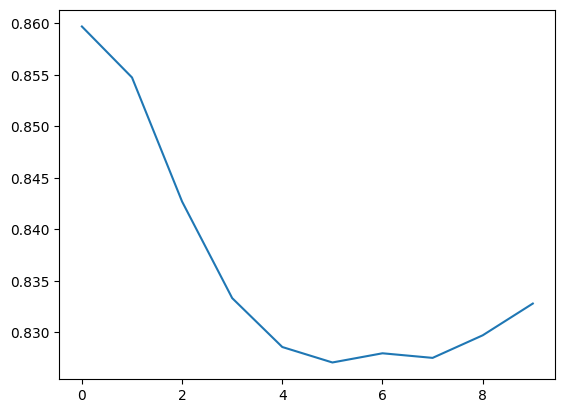

In [33]:
plt.plot(history)

In [34]:
val_df[0]['labels'][:,0]

tensor([-100], device='cuda:0')

In [35]:
support_dataset['train']['ner_tags'][0]

[0,
 0,
 0,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

## Evaluation

In [36]:
test_df = ImageLayoutDataset(
    support_dataset['test'],
    tokenizer,
    tokenize_all_labels=True,
    valid_labels_keymap=valid_labels_funsd
)

  0%|          | 0/347 [00:00<?, ?it/s]

100%|██████████| 347/347 [00:02<00:00, 143.48it/s]


In [37]:
with torch.no_grad():
    h = []
    y = []
    for document_idx in tqdm(range(n_shots)):

        X_p = 0
        s_X = 0
        n_p = 0

        size = support_df[document_idx]['labels'].shape[1]
        input = support_df[document_idx]

        out = model(
            input_ids=input['input_ids'].reshape(1,-1), 
            bbox= input['bbox'].reshape([1, 512, 4]),
            attention_mask=input['attention_mask'].reshape(1,-1), 
            token_type_ids=input['token_type_ids'].reshape(1,-1),
        )

        for i in range(size):
            if support_df[document_idx]['labels'][:,i] == -100:
                continue
            v = out\
                .last_hidden_state[:,i,:]\
                .cpu()\
                .numpy()\
                .reshape(-1)
            
            label = support_df[document_idx]['labels'][:,i].item()
            
            h.append(v)
            y.append(label)

    knn.fit(h,y)

    h = []
    y = []
    for document_idx in tqdm((range(len(test_df)))):
    

        X_p = 0
        s_X = 0
        n_p = 0

        size = test_df[document_idx]['labels'].shape[1]
        input = test_df[document_idx]

        out = model(
            input_ids=input['input_ids'].reshape(1,-1), 
            bbox= input['bbox'].reshape([1, 512, 4]),
            attention_mask=input['attention_mask'].reshape(1,-1), 
            token_type_ids=input['token_type_ids'].reshape(1,-1),
        )

        for i in range(size):
            if test_df[document_idx]['labels'][:,i] == -100:
                continue
            v = out\
                .last_hidden_state[:,i,:]\
                .cpu()\
                .numpy()\
                .reshape(-1)
            
            label = test_df[document_idx]['labels'][:,i].item()
            
            h.append(v)
            y.append(label)

    pred = knn.predict(h)
    f1= f1_score(y, pred, average='micro')
    conf_matrix = confusion_matrix(y, pred)

    print(f"f1: {f1}")
    print(conf_matrix)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 347/347 [00:15<00:00, 23.09it/s]


f1: 0.8366101310340915
[[64072  1978     0  7657     0]
 [  435  2058     0   414     0]
 [ 1545    29     0   126     0]
 [  371   716     0  7613     0]
 [ 1093     8     0    30     0]]


## Few shot learning on support domain - 5 shots

In [34]:
support_dataset['train'].features['ner_tags'].feature.names

['O',
 'B-HEADER',
 'I-HEADER',
 'B-QUESTION',
 'I-QUESTION',
 'B-ANSWER',
 'I-ANSWER']

In [38]:
n_shots = 5
# valid_labels_funsd = {
#     0: 0,
#     1:1,
#     2:1,
#     3:2,
#     4:2,
#     5:3,
#     6:3
# }

support_df = ImageLayoutDataset(
    support_dataset['train'],
    tokenizer,
    valid_labels_keymap=valid_labels_funsd
)

100%|██████████| 626/626 [00:04<00:00, 144.31it/s]


In [39]:
input_dim = 768
output_dim = 64

f_mean = F_mean(
    input_dim,
    output_dim
)

f_cov = F_cov(
    input_dim,
    output_dim
)

f_mean.load_state_dict(torch.load(checkpoint_f_mean))
f_cov.load_state_dict(torch.load(checkpoint_f_cov))

model =AutoModel.from_pretrained(
    checkpoint_llm,
    cache_dir = '/Data/pedro.silva/'
).to(device)

In [40]:
params = list(f_mean.parameters()) + list(f_cov.parameters()) + list(model.parameters())
optimizer_support = torch.optim.Adam(
    params,
    lr = 1e-4
)

In [41]:
loss_prev = torch.inf
loss_ft = 1e100
loss_ft < loss_prev

True

In [42]:
val_df = ImageLayoutDataset(
    support_dataset['train'],
    tokenizer,
    tokenize_all_labels=True,
    valid_labels_keymap=valid_labels_funsd
)

100%|██████████| 626/626 [00:05<00:00, 120.78it/s]


In [43]:
loss_prev = torch.inf
loss_ft = 1e100
n_epochs = 5
n_shots = 5

knn = KNeighborsClassifier(n_neighbors=5)

best_f1 = -1
history = []

for epoch in range(n_epochs):
    

    loss_prev = loss_ft
    loss_ft = 0
    total_points = 0
    for document_idx in tqdm(range(n_shots)):
        means = {}
        covs = {}
        X_p = 0
        s_X = 0
        n_p = 0

        size = support_df[document_idx]['labels'].shape[1]
        input = support_df[document_idx]

        out = model(
            input_ids=input['input_ids'].reshape(1,-1), 
            bbox= input['bbox'].reshape([1, 512, 4]),
            attention_mask=input['attention_mask'].reshape(1,-1), 
            token_type_ids=input['token_type_ids'].reshape(1,-1),
        )

        for i in range(size):
            if support_df[document_idx]['labels'][:,i] == -100:
                continue
            mu_i = f_mean(out.last_hidden_state[:,i,:])
            cov_i = f_cov(out.last_hidden_state[:,i, :])

            means[i] = mu_i
            covs[i] = cov_i

        del out

        for i in range(size):
            if support_df[document_idx]['labels'][:,i] == -100:
                continue

            total_points+= 1
            for j in range(i+1, size):
                if support_df[document_idx]['labels'][:,j] == -100:
                    continue

                # mu_i = f_mean(out.last_hidden_state[:,i,:])
                # cov_i = f_cov(out.last_hidden_state[:,i, :])
                # mu_j = f_mean(out.last_hidden_state[:,j,:])
                # cov_j = f_cov(out.last_hidden_state[:,j, :])
                mu_i = means[i]
                cov_i = covs[i]
                mu_j = means[j]
                cov_j = covs[j]
                d_ij = 1/2 * (KL_div(mu_i, mu_j, cov_i, cov_j) + KL_div(mu_j, mu_i, cov_j, cov_i))

                if support_df[document_idx]['labels'][:,i] == support_df[document_idx]['labels'][:,j]:
                    X_p += torch.exp(-d_ij)
                    n_p += 1

                s_X += torch.exp(-d_ij)

        del means
        del covs

        loss_ft -= torch.log(X_p / n_p / s_X)
        

    loss_ft = loss_ft/total_points
    clear_output()
    print(f"epoch {epoch}")
    print(f"loss: {loss_ft.item()}")

    loss_ft.backward()

    optimizer_support.step()

    optimizer_support.zero_grad()

    # validation
    print("running validation")
    
    with torch.no_grad():
        h = []
        y = []
        for document_idx in tqdm(range(n_shots)):
            

            X_p = 0
            s_X = 0
            n_p = 0

            size = support_df[document_idx]['labels'].shape[1]
            input = support_df[document_idx]

            out = model(
                input_ids=input['input_ids'].reshape(1,-1), 
                bbox= input['bbox'].reshape([1, 512, 4]),
                attention_mask=input['attention_mask'].reshape(1,-1), 
                token_type_ids=input['token_type_ids'].reshape(1,-1),
            )

            for i in range(size):
                if support_df[document_idx]['labels'][:,i] == -100:
                    continue
                v = out\
                    .last_hidden_state[:,i,:]\
                    .cpu()\
                    .numpy()\
                    .reshape(-1)
                
                label = support_df[document_idx]['labels'][:,i].item()
                
                h.append(v)
                y.append(label)

        knn.fit(h,y)
        h = []
        y = []
        for document_idx in tqdm(range(n_shots, n_shots+100)):
            

            
            size = val_df[document_idx]['labels'].shape[1]
            input = val_df[document_idx]

            out = model(
                input_ids=input['input_ids'].reshape(1,-1), 
                bbox= input['bbox'].reshape([1, 512, 4]),
                attention_mask=input['attention_mask'].reshape(1,-1), 
                token_type_ids=input['token_type_ids'].reshape(1,-1),
            )

            for i in range(size):
                if val_df[document_idx]['labels'][:,i] == -100:
                    continue
                v = out\
                    .last_hidden_state[:,i,:]\
                    .cpu()\
                    .numpy()\
                    .reshape(-1)
                
                label = val_df[document_idx]['labels'][:,i].item()
                
                h.append(v)
                y.append(label)

        pred = knn.predict(h)
        f1= f1_score(y, pred, average='micro')
        conf_matrix = confusion_matrix(y, pred)

        print(f"f1: {f1}")
        print(conf_matrix)

        history.append(f1)
        if f1 > best_f1:
            best_model = deepcopy(model)
            best_f1 = f1


best_model.push_to_hub(f"peulsilva/container-source-funsd-sroie-{n_shots}shots")
torch.save(f_mean.state_dict(), f"/Data/pedro.silva/f_mean_funsd-{n_shots}.pt")
torch.save(f_cov.state_dict(), f"/Data/pedro.silva/f_cov_funsd-{n_shots}.pt")


epoch 4
loss: 0.0746937245130539
running validation


100%|██████████| 100/100 [00:04<00:00, 22.87it/s]


f1: 0.8577475680735887
[[18431   449     0  1554     0]
 [  184   584     1    31     0]
 [  409    32     0    36     0]
 [  177   302     0  2059     0]
 [  320     0     0     0     0]]


model.safetensors:   0%|          | 0.00/451M [00:00<?, ?B/s]

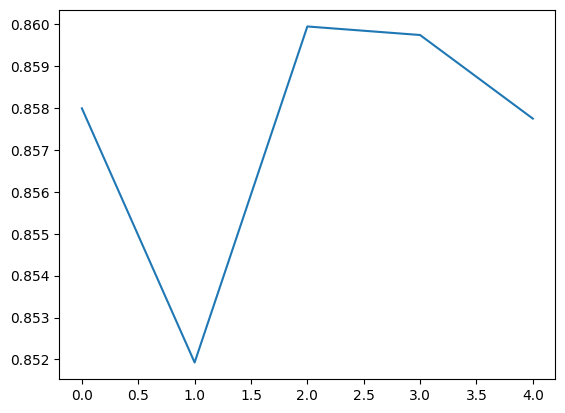

In [44]:
plt.plot(history)

In [45]:
val_df[0]['labels'][:,0]

tensor([-100], device='cuda:0')

In [46]:
support_dataset['train']['ner_tags'][0]

[0,
 0,
 0,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

## Evaluation

In [47]:
test_df = ImageLayoutDataset(
    support_dataset['test'],
    tokenizer,
    tokenize_all_labels=True,
    valid_labels_keymap=valid_labels_funsd
)

  0%|          | 0/347 [00:00<?, ?it/s]

100%|██████████| 347/347 [00:02<00:00, 145.39it/s]


In [48]:
with torch.no_grad():
    h = []
    y = []
    for document_idx in tqdm(range(n_shots)):

        X_p = 0
        s_X = 0
        n_p = 0

        size = support_df[document_idx]['labels'].shape[1]
        input = support_df[document_idx]

        out = model(
            input_ids=input['input_ids'].reshape(1,-1), 
            bbox= input['bbox'].reshape([1, 512, 4]),
            attention_mask=input['attention_mask'].reshape(1,-1), 
            token_type_ids=input['token_type_ids'].reshape(1,-1),
        )

        for i in range(size):
            if support_df[document_idx]['labels'][:,i] == -100:
                continue
            v = out\
                .last_hidden_state[:,i,:]\
                .cpu()\
                .numpy()\
                .reshape(-1)
            
            label = support_df[document_idx]['labels'][:,i].item()
            
            h.append(v)
            y.append(label)

    knn.fit(h,y)

    h = []
    y = []
    for document_idx in tqdm((range(len(test_df)))):
    

        X_p = 0
        s_X = 0
        n_p = 0

        size = test_df[document_idx]['labels'].shape[1]
        input = test_df[document_idx]

        out = model(
            input_ids=input['input_ids'].reshape(1,-1), 
            bbox= input['bbox'].reshape([1, 512, 4]),
            attention_mask=input['attention_mask'].reshape(1,-1), 
            token_type_ids=input['token_type_ids'].reshape(1,-1),
        )

        for i in range(size):
            if test_df[document_idx]['labels'][:,i] == -100:
                continue
            v = out\
                .last_hidden_state[:,i,:]\
                .cpu()\
                .numpy()\
                .reshape(-1)
            
            label = test_df[document_idx]['labels'][:,i].item()
            
            h.append(v)
            y.append(label)

    pred = knn.predict(h)
    f1= f1_score(y, pred, average='micro')
    conf_matrix = confusion_matrix(y, pred)

    print(f"f1: {f1}")
    print(conf_matrix)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 347/347 [00:15<00:00, 23.09it/s]


f1: 0.8552044925974247
[[66045  1529     3  6130     0]
 [  552  2267     2    86     0]
 [ 1550    57     0    93     0]
 [  666   964     0  7070     0]
 [ 1131     0     0     0     0]]


## Few shot learning on support domain - 10 shots

In [21]:
support_dataset['train'].features['ner_tags'].feature.names

['O',
 'B-HEADER',
 'I-HEADER',
 'B-QUESTION',
 'I-QUESTION',
 'B-ANSWER',
 'I-ANSWER']

In [22]:
n_shots = 10
valid_labels_funsd = {
    0: 0,
    1:1,
    2:1,
    3:2,
    4:2,
    5:3,
    6:3
}

support_df = ImageLayoutDataset(
    support_dataset['train'],
    tokenizer,
    valid_labels_keymap=valid_labels_funsd
)

  0%|          | 0/149 [00:00<?, ?it/s]

100%|██████████| 149/149 [00:01<00:00, 131.71it/s]


In [23]:
input_dim = 768
output_dim = 64

f_mean = F_mean(
    input_dim,
    output_dim
)

f_cov = F_cov(
    input_dim,
    output_dim
)

f_mean.load_state_dict(torch.load(checkpoint_f_mean))
f_cov.load_state_dict(torch.load(checkpoint_f_cov))

model =AutoModel.from_pretrained(
    checkpoint_llm,
    cache_dir = '/Data/pedro.silva/'
).to(device)

In [24]:
params = list(f_mean.parameters()) + list(f_cov.parameters()) + list(model.parameters())
optimizer_support = torch.optim.Adam(
    params,
    lr = 1e-4
)

In [25]:
loss_prev = torch.inf
loss_ft = 1e100
loss_ft < loss_prev

True

In [26]:
val_df = ImageLayoutDataset(
    support_dataset['train'],
    tokenizer,
    tokenize_all_labels=True,
    valid_labels_keymap=valid_labels_funsd
)

  0%|          | 0/149 [00:00<?, ?it/s]

100%|██████████| 149/149 [00:01<00:00, 137.94it/s]


In [27]:
loss_prev = torch.inf
loss_ft = 1e100
n_epochs = 10
n_shots = 10

knn = KNeighborsClassifier(n_neighbors=5)

best_f1 = -1
history = []

for epoch in range(n_epochs):
    

    loss_prev = loss_ft
    loss_ft = 0
    total_points = 0
    for document_idx in tqdm(range(n_shots)):
        means = {}
        covs = {}
        X_p = 0
        s_X = 0
        n_p = 0

        size = support_df[document_idx]['labels'].shape[1]
        input = support_df[document_idx]

        out = model(
            input_ids=input['input_ids'].reshape(1,-1), 
            bbox= input['bbox'].reshape([1, 512, 4]),
            attention_mask=input['attention_mask'].reshape(1,-1), 
            token_type_ids=input['token_type_ids'].reshape(1,-1),
        )

        for i in range(size):
            if support_df[document_idx]['labels'][:,i] == -100:
                continue
            mu_i = f_mean(out.last_hidden_state[:,i,:])
            cov_i = f_cov(out.last_hidden_state[:,i, :])

            means[i] = mu_i
            covs[i] = cov_i

        del out

        for i in range(size):
            if support_df[document_idx]['labels'][:,i] == -100:
                continue

            total_points+= 1
            for j in range(i+1, size):
                if support_df[document_idx]['labels'][:,j] == -100:
                    continue

                # mu_i = f_mean(out.last_hidden_state[:,i,:])
                # cov_i = f_cov(out.last_hidden_state[:,i, :])
                # mu_j = f_mean(out.last_hidden_state[:,j,:])
                # cov_j = f_cov(out.last_hidden_state[:,j, :])
                mu_i = means[i]
                cov_i = covs[i]
                mu_j = means[j]
                cov_j = covs[j]
                d_ij = 1/2 * (KL_div(mu_i, mu_j, cov_i, cov_j) + KL_div(mu_j, mu_i, cov_j, cov_i))

                if support_df[document_idx]['labels'][:,i] == support_df[document_idx]['labels'][:,j]:
                    X_p += torch.exp(-d_ij)
                    n_p += 1

                s_X += torch.exp(-d_ij)

        del means
        del covs

        loss_ft -= torch.log(X_p / n_p / s_X)
        

    loss_ft = loss_ft/total_points
    clear_output()
    print(f"epoch {epoch}")
    print(f"loss: {loss_ft.item()}")

    loss_ft.backward()

    optimizer_support.step()

    optimizer_support.zero_grad()

    # validation
    print("running validation")
    
    with torch.no_grad():
        h = []
        y = []
        for document_idx in tqdm(range(n_shots)):
            

            X_p = 0
            s_X = 0
            n_p = 0

            size = support_df[document_idx]['labels'].shape[1]
            input = support_df[document_idx]

            out = model(
                input_ids=input['input_ids'].reshape(1,-1), 
                bbox= input['bbox'].reshape([1, 512, 4]),
                attention_mask=input['attention_mask'].reshape(1,-1), 
                token_type_ids=input['token_type_ids'].reshape(1,-1),
            )

            for i in range(size):
                if support_df[document_idx]['labels'][:,i] == -100:
                    continue
                v = out\
                    .last_hidden_state[:,i,:]\
                    .cpu()\
                    .numpy()\
                    .reshape(-1)
                
                label = support_df[document_idx]['labels'][:,i].item()
                
                h.append(v)
                y.append(label)

        knn.fit(h,y)
        h = []
        y = []
        for document_idx in tqdm(range(n_shots, n_shots+100)):
            

            
            size = val_df[document_idx]['labels'].shape[1]
            input = val_df[document_idx]

            out = model(
                input_ids=input['input_ids'].reshape(1,-1), 
                bbox= input['bbox'].reshape([1, 512, 4]),
                attention_mask=input['attention_mask'].reshape(1,-1), 
                token_type_ids=input['token_type_ids'].reshape(1,-1),
            )

            for i in range(size):
                if val_df[document_idx]['labels'][:,i] == -100:
                    continue
                v = out\
                    .last_hidden_state[:,i,:]\
                    .cpu()\
                    .numpy()\
                    .reshape(-1)
                
                label = val_df[document_idx]['labels'][:,i].item()
                
                h.append(v)
                y.append(label)

        pred = knn.predict(h)
        f1= f1_score(y, pred, average='micro')
        conf_matrix = confusion_matrix(y, pred)

        print(f"f1: {f1}")
        print(conf_matrix)

        history.append(f1)
        if f1 > best_f1:
            best_model = deepcopy(model)
            best_f1 = f1


best_model.push_to_hub(f"peulsilva/container-source-sroie-funsd-{n_shots}shots")
torch.save(f_mean.state_dict(), f"/Data/pedro.silva/f_mean_sroie-{n_shots}.pt")
torch.save(f_cov.state_dict(), f"/Data/pedro.silva/f_cov_sroie-{n_shots}.pt")


epoch 9
loss: 0.05265926569700241
running validation


100%|██████████| 100/100 [00:04<00:00, 23.60it/s]


f1: 0.4387384269274033
[[ 783  318  994 1662]
 [ 130  504  320  293]
 [1307  667 2424 3164]
 [1530  461 2127 6430]]


model.safetensors:   0%|          | 0.00/451M [00:00<?, ?B/s]

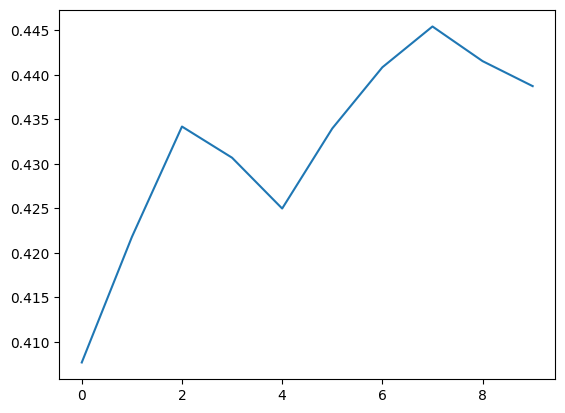

In [28]:
plt.plot(history)

In [29]:
val_df[0]['labels'][:,0]

tensor([-100], device='cuda:0')

In [30]:
support_dataset['train']['ner_tags'][0]

[0,
 3,
 3,
 3,
 5,
 3,
 3,
 0,
 1,
 2,
 2,
 2,
 2,
 2,
 3,
 4,
 4,
 4,
 4,
 5,
 6,
 6,
 6,
 6,
 6,
 5,
 6,
 6,
 3,
 4,
 5,
 6,
 6,
 3,
 4,
 4,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 3,
 4,
 4,
 4,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 1,
 2,
 2,
 2,
 2,
 2,
 3,
 4,
 5,
 6,
 6,
 6,
 6,
 6,
 5,
 6,
 6,
 6,
 6,
 0,
 0,
 0]

## Evaluation

In [31]:
test_df = ImageLayoutDataset(
    support_dataset['test'],
    tokenizer,
    tokenize_all_labels=True,
    valid_labels_keymap=valid_labels_funsd
)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 101.79it/s]


In [32]:
with torch.no_grad():
    h = []
    y = []
    for document_idx in tqdm(range(n_shots)):

        X_p = 0
        s_X = 0
        n_p = 0

        size = support_df[document_idx]['labels'].shape[1]
        input = support_df[document_idx]

        out = model(
            input_ids=input['input_ids'].reshape(1,-1), 
            bbox= input['bbox'].reshape([1, 512, 4]),
            attention_mask=input['attention_mask'].reshape(1,-1), 
            token_type_ids=input['token_type_ids'].reshape(1,-1),
        )

        for i in range(size):
            if support_df[document_idx]['labels'][:,i] == -100:
                continue
            v = out\
                .last_hidden_state[:,i,:]\
                .cpu()\
                .numpy()\
                .reshape(-1)
            
            label = support_df[document_idx]['labels'][:,i].item()
            
            h.append(v)
            y.append(label)

    knn.fit(h,y)

    h = []
    y = []
    for document_idx in tqdm((range(len(test_df)))):
    

        X_p = 0
        s_X = 0
        n_p = 0

        size = test_df[document_idx]['labels'].shape[1]
        input = test_df[document_idx]

        out = model(
            input_ids=input['input_ids'].reshape(1,-1), 
            bbox= input['bbox'].reshape([1, 512, 4]),
            attention_mask=input['attention_mask'].reshape(1,-1), 
            token_type_ids=input['token_type_ids'].reshape(1,-1),
        )

        for i in range(size):
            if test_df[document_idx]['labels'][:,i] == -100:
                continue
            v = out\
                .last_hidden_state[:,i,:]\
                .cpu()\
                .numpy()\
                .reshape(-1)
            
            label = test_df[document_idx]['labels'][:,i].item()
            
            h.append(v)
            y.append(label)

    pred = knn.predict(h)
    f1= f1_score(y, pred, average='micro')
    conf_matrix = confusion_matrix(y, pred)

    print(f"f1: {f1}")
    print(conf_matrix)

100%|██████████| 50/50 [00:02<00:00, 22.88it/s]


f1: 0.44657361406829116
[[1244  292  747 1145]
 [  83  211   97  116]
 [ 561  339 1073 1681]
 [ 829  176  952 3135]]
